In [1]:
#default_exp ensemble

In [2]:
#hide
from nbdev.showdoc import *

# Meta Estimators

> A set of Meta Estimators suited for density estimation

- [ ] Understand sklearns StackedRegressor architecture

In [3]:
#export
import sklearn.ensemble as ensemble
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, normalize
import numpy as np
import dill

## MultiOutputRegressor - 

In [4]:
#export
from sklearn.multioutput import MultiOutputRegressor
class CustomMultiOutputRegressor(MultiOutputRegressor):
    '''Custom multioutput for multioutput cases except random forests (which handles multi output directly)'''
    def apply(self,X):
        result = [estim.apply(X) for estim in self.estimators_]
        return np.concatenate(result, axis = -1)
    def sample(self, X, sample_size = 10, weights = None):        
        PRECISA MUDAR ESSA LINHA, TENTAR AMOSTRAR POR INDICES result = np.array([estim.sample(X, sample_size = sample_size, weights = weights) for estim in self.estimators_])
        result = np.swapaxes(result,0,1)
        result = np.swapaxes(result,1,2)
        return result

## TransformedTarget Estimator -

We will create a bimodal dataset for exemplification

You can create an estimator that performs Normlization during fit and inverse transforms the result during inferencce

In [7]:
from sklearn.linear_model import LinearRegression

TransformedTargetEstimator(LinearRegression)().fit_predict(X_train, y_train)

array([[-278.59411738,  350.28386453],
       [ 397.97407895,  433.59932116],
       [-186.44723216, -365.51766798],
       ...,
       [-321.31306604, -406.05520147],
       [-424.57846312, -516.5814212 ],
       [ 104.76912719,  -97.37079303]])

## Bagging Estimator - 

## ADABoost Estimator -

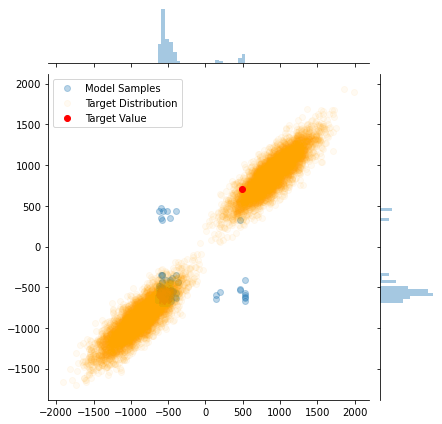

## Stacked Estimator -



SyntaxError: invalid syntax (<ipython-input-107-c77bbbea5356>, line 20)

functools.partial(<function _empirical_sample at 0x0000022B61C010D8>, dist=None, sample_size=10)
functools.partial(<function _empirical_sample at 0x0000022B61C010D8>, dist=None, sample_size=10)


AttributeError: 'BaggingDensityEstimator' object has no attribute '_default_stacking_methods'